In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
%config NotebookApp.iopub_msg_rate_limit=10000
import time

In [2]:
movies = pd.read_json("movies.json")
reviews = pd.read_json("reviews.json")

In [3]:
reviews = reviews.drop(['timestamp'], axis=1)
reviews.head()

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


In [4]:
len(reviews['user_id'].unique())

942

In [5]:
movies.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
def findModes(lst, n):
    counter = Counter(lst)
    modes = counter.most_common(n)
    return [mode[0] for mode in modes]

In [7]:
#using the elbow plot I got in the last exit ticket with this same data, 3-4 was the optimal number of top movies to check

numTopMovies = 4
modes = findModes(reviews['item_id'], numTopMovies)
print(modes)
filteredReviews = reviews[reviews['item_id'].isin(modes)].copy().reset_index(drop=True)
filteredReviews.head()

[50, 258, 100, 181]


,user_id,item_id,rating
0,0,50,5
1,251,100,4
2,25,181,5
3,26,258,3
4,194,181,3


In [8]:
pivotDF = filteredReviews.pivot(index='user_id', columns='item_id', values='rating')
pivotDF.dropna(axis=0, how='all')
pivotDF.fillna(-1, inplace=True)
pivotDF.head()

item_id,50,100,181,258
user_id,,,,
0,5.0,-1.0,-1.0,-1.0
1,5.0,5.0,5.0,5.0
2,5.0,5.0,-1.0,3.0
3,-1.0,-1.0,4.0,2.0
4,5.0,-1.0,-1.0,5.0


In [9]:
bandMin = 0.2
bandMax = 5.6
bandStep = 0.2
currentBand = bandMin
scores = {}
while currentBand <= (bandMax+(bandStep/2)):
    ms = MeanShift(bandwidth=currentBand)
    ms.fit(pivotDF)
    labels = ms.labels_
    if len(set(ms.labels_)) > 1:
        ss_avg = silhouette_score(pivotDF, labels)
        scores[round(currentBand,1)] = ss_avg
    else:
        scores[round(currentBand,1)] = -5
    percentDone = round(((currentBand-bandMin)/bandStep)/((bandMax-bandMin)/bandStep)*100,2)
    clear_output(wait=True)
    time.sleep(0.001)
    print(str(percentDone) + "% done")
    currentBand += bandStep

100.0% done


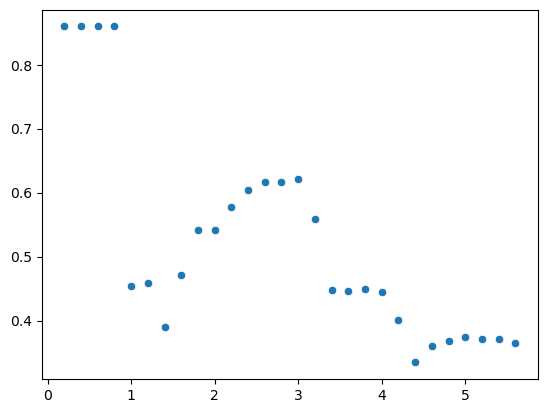

In [10]:
sns.scatterplot(x=scores.keys(), y=scores.values()) #3 is the optimal bandwidth
plt.show()

In [11]:
scores

{0.2: 0.8597122302158273,
 0.4: 0.8597122302158273,
 0.6: 0.8597122302158273,
 0.8: 0.8597122302158273,
 1.0: 0.454850853806773,
 1.2: 0.4586523881763648,
 1.4: 0.39008442850125613,
 1.6: 0.4707398188028603,
 1.8: 0.5423131105500083,
 2.0: 0.5418638525217608,
 2.2: 0.5775440838600399,
 2.4: 0.6034249640415538,
 2.6: 0.6167852177148203,
 2.8: 0.6165284724854774,
 3.0: 0.6206282302900177,
 3.2: 0.5580515695317823,
 3.4: 0.448380628778229,
 3.6: 0.44653222007361787,
 3.8: 0.4495066595348507,
 4.0: 0.4451199869761106,
 4.2: 0.4007234938565848,
 4.4: 0.3345876839215532,
 4.6: 0.3601417452833533,
 4.8: 0.3681286320751625,
 5.0: 0.3746324094931507,
 5.2: 0.37163087497417224,
 5.4: 0.37144611241290465,
 5.6: 0.3642893585501153}

In [12]:
bw = 3
ms = MeanShift(bandwidth=bw)
ms.fit(pivotDF)
labels = ms.labels_

In [13]:
pivotDF["cluster"] = ms.labels_
pivotDF.reset_index(inplace=True)
pivotDF.head()

item_id,user_id,50,100,181,258,cluster
0,0,5.0,-1.0,-1.0,-1.0,9
1,1,5.0,5.0,5.0,5.0,0
2,2,5.0,5.0,-1.0,3.0,8
3,3,-1.0,-1.0,4.0,2.0,15
4,4,5.0,-1.0,-1.0,5.0,10


In [14]:
len(set(ms.labels_))

16

In [15]:
pivotDF.loc[pivotDF.loc[:,'user_id'] == 186]

item_id,user_id,50,100,181,258,cluster
170,186,-1.0,4.0,-1.0,1.0,5


In [16]:
pivotDF.loc[pivotDF.loc[:,'cluster'] == 5]

item_id,user_id,50,100,181,258,cluster
16,16,-1.0,5.0,-1.0,-1.0,5
17,17,-1.0,4.0,-1.0,-1.0,5
45,50,-1.0,2.0,-1.0,-1.0,5
67,73,-1.0,4.0,-1.0,-1.0,5
69,75,-1.0,5.0,-1.0,-1.0,5
...,...,...,...,...,...,...
773,874,-1.0,4.0,-1.0,-1.0,5
786,888,-1.0,4.0,-1.0,-1.0,5
798,900,-1.0,4.0,-1.0,-1.0,5
804,906,-1.0,4.0,-1.0,-1.0,5


In [17]:
clusterUsers = pivotDF.loc[pivotDF.loc[:,'cluster'] == 5]['user_id'].unique()
recomendDF = reviews.loc[reviews['user_id'].isin(clusterUsers)].reset_index(drop=True)
moviesSeen = recomendDF.loc[recomendDF.loc[:,'user_id'] == 186]['item_id'].unique()
recomendDF = recomendDF[~recomendDF['item_id'].isin(moviesSeen)].reset_index(drop=True)
recomendDF = recomendDF.pivot(index='user_id', columns='item_id', values='rating')
recomendDF.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1535,1536,1545,1558,1573,1600,1602,1612,1628,1642
user_id,,,,,,,,,,,,,,,,,,,,,
16,5.0,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
item_means = pd.DataFrame(recomendDF.mean(axis=0))
item_means

,0
item_id,
1,3.954545
2,3.000000
3,3.000000
4,3.600000
5,3.000000
...,...
1600,5.000000
1602,3.000000
1612,1.000000


In [19]:
item_means.idxmax()


0    18
dtype: int64

In [20]:
movies.loc[movies.loc[:,'item_id'] == 18]

,item_id,title
17,18,"White Balloon, The (1995)"


In [21]:
item_means.iloc[57]

0    4.5
Name: 76, dtype: float64